In [1]:
import os
import glob
import sys
sys.path.append('/Users/aghavamp/Desktop/Projects')
sys.path.append('/Users/aghavamp/Desktop/Projects/bimanual_wrist')
sys.path.append('/Users/aghavamp/Desktop/Projects/Functional_Fusion')
sys.path.append('/Users/aghavamp/Desktop/Projects/PcmPy')
import getpass
import importlib
from tqdm import tqdm
from pathlib import Path

import rsatoolbox as rsa
from rsatoolbox.io import spm as spm_io
import nibabel as nb
import nitools as nt
import PcmPy as pcm
import Functional_Fusion.atlas_map as am
import Functional_Fusion.reliability as rel

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
import seaborn as sns

import scipy.io as sio
import numpy as np
import pandas as pd

import utils
importlib.reload(utils)

# SET PATHS:
baseDir = os.path.join('/Users', getpass.getuser(), 'Desktop', 'Projects', 'bimanual_wrist', 'data', 'fMRI')
bidsDir = 'BIDS'
anatomicalDir = 'anatomicals'
freesurferDir = 'surfaceFreesurfer'
surfacewbDir = 'surfaceWB' 
behavDir = 'behavioural'
regDir = 'ROI'
atlasDir = '/Volumes/diedrichsen_data$/data/Atlas_templates/fs_LR_32'
analysisDir = os.path.join(os.path.dirname(os.path.dirname(baseDir)), 'analysis')



# make dataset

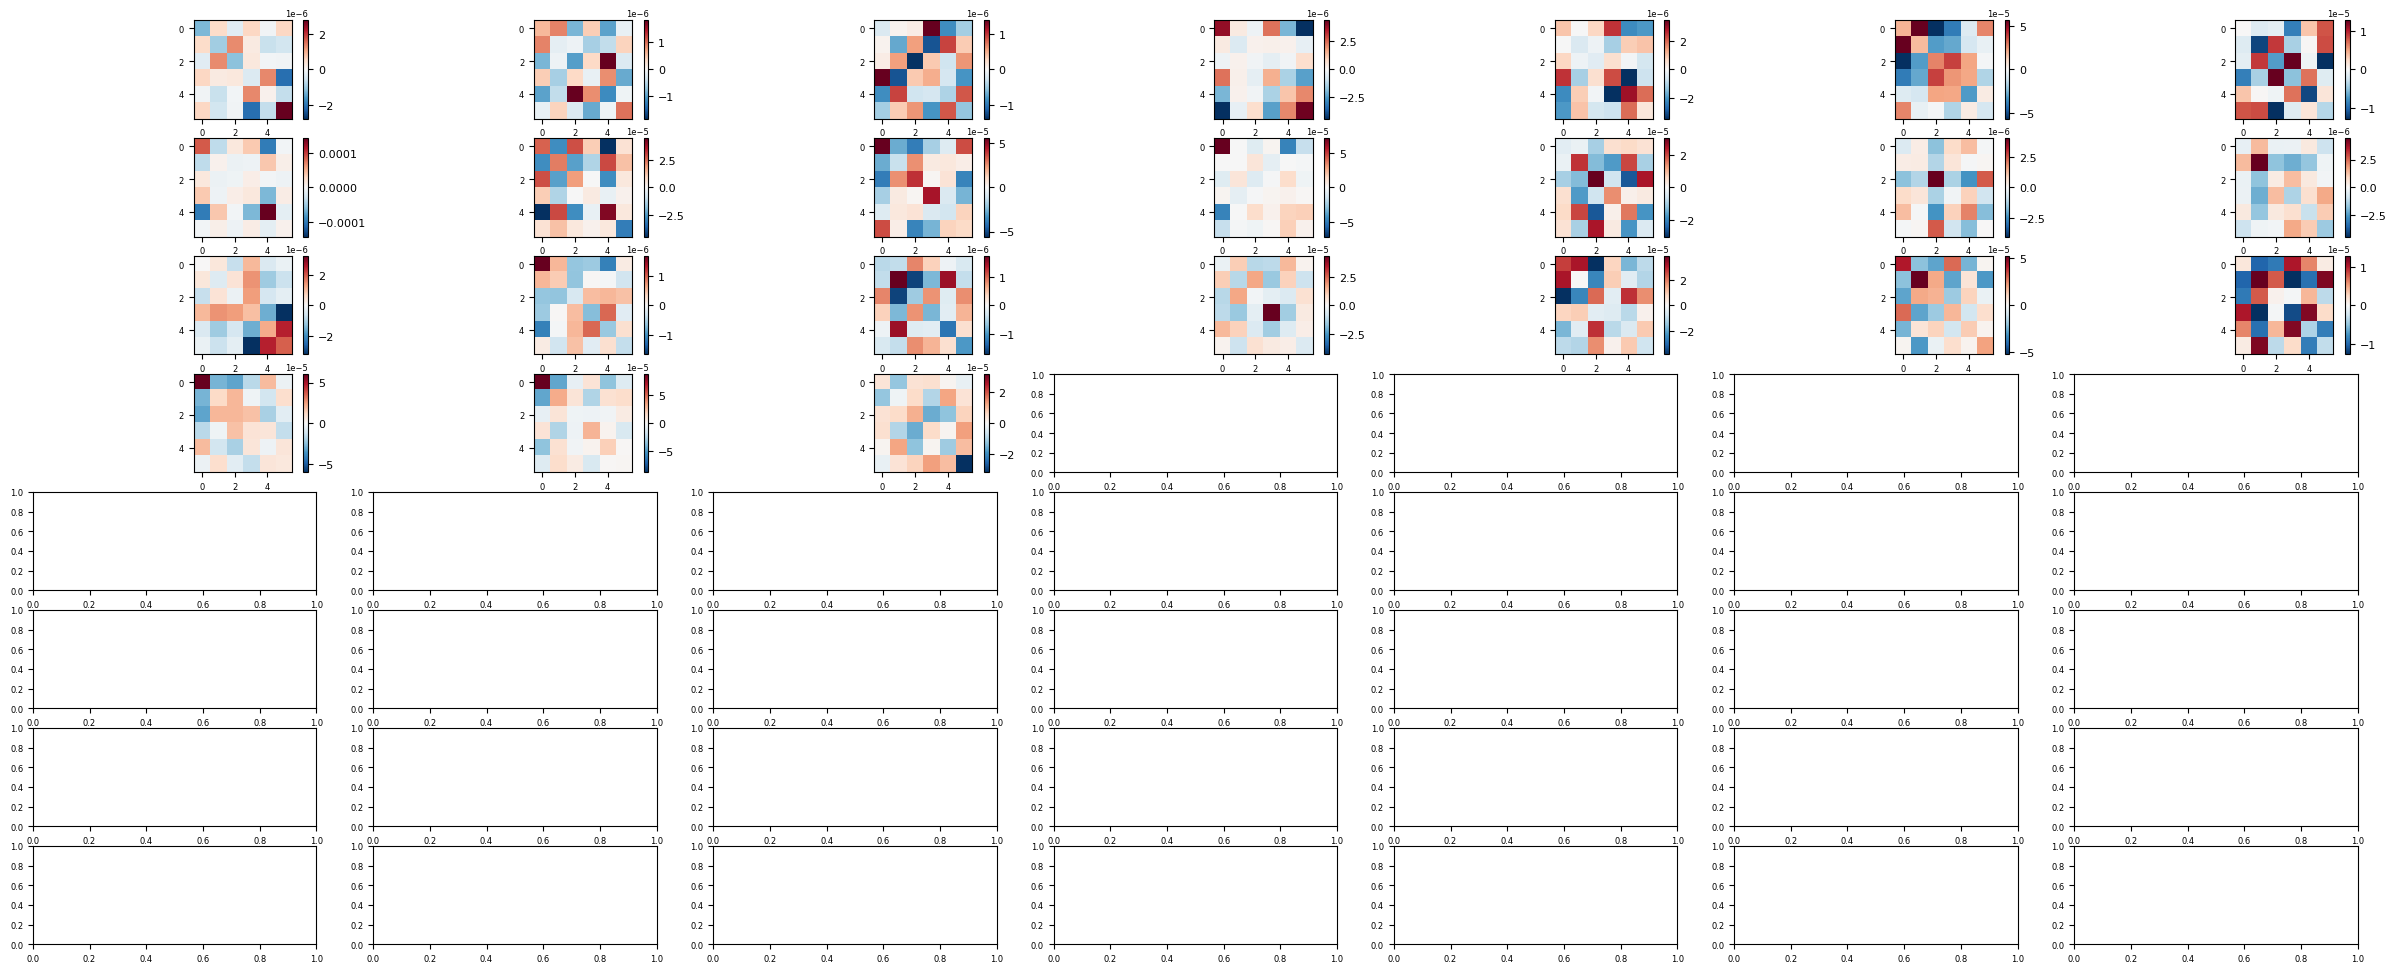

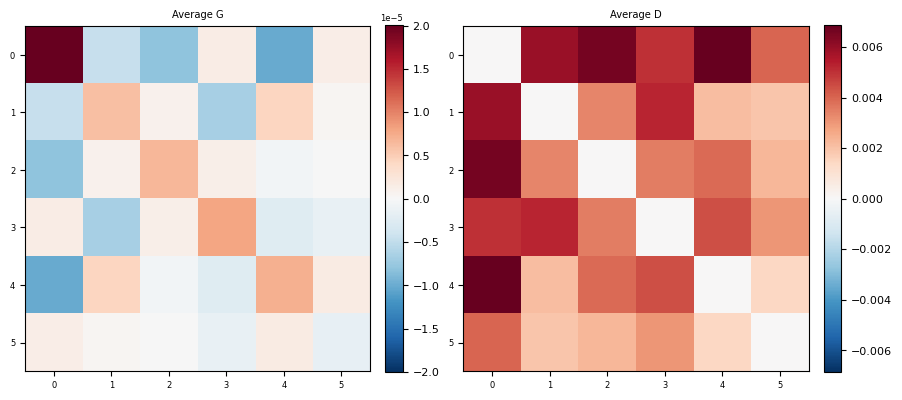

In [18]:
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
cmap = 'RdBu_r' 
sn_bad = [102, 103]

region = 'PMd'

conditions = ['lhand', 'rhand']
rois = [f'{region}_R',f'{region}_L']
data, cond_vec, part_vec = [], [], []
for roi, condition in zip(rois, conditions):
    file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
    d = np.load(file_path, allow_pickle=True)

    subject = d['subject']
    indices = [k for k, s in enumerate(subject) if s not in sn_bad]
    
    subject = d['subject'][indices]
    cond_name_tmp = d['cond_intrinsic_vec'][indices]
    cond_vec_tmp = d['cond_num_vec'][indices]
    data_tmp = d['beta_white'][indices]
    part_tmp = d['part_vec'][indices]
    
    for i_sub in range(len(subject)):
        # Filter for the current condition
        if condition == 'lhand_marginal':
            Y = []
            subj_part = []
            subj_cond = []
            # loop on each direction
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that left hand goes in that direction:
                    tmp_name = f'bi:{direction}_'
                    idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'lhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        if condition == 'rhand_marginal':
            Y = []
            subj_part = []
            subj_cond = []
            # loop on each direction
            for cond_num, direction in enumerate(labels):
                # in each partition:
                for k in range(1,11):
                    # bimanual trials that right hand goes in that direction:
                    tmp_name = f'_{direction}'
                    idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                    idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                    idx = idx1 & idx2
                    y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                    Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                condition_name = f'rhand:{direction}'
                # find the condition numbers corresponding to this condition:
                idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

        if condition == 'lhand' or condition == 'rhand':
            # Filter for the current condition
            idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
            Y = data_tmp[i_sub][idx, :]
            subj_cond = cond_vec_tmp[i_sub][idx]
            subj_part = part_tmp[i_sub][idx]

        data.append(Y)
        cond_vec.append(np.array(subj_cond))
        part_vec.append(subj_part)

Y = []
for i_sub in range(len(data)):
    obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
    Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

# --- RDM Calculation ---
N = len(Y)
ncond = len(np.unique(Y[0].obs_descriptors['cond_vec']))
G_hat = np.zeros((N, ncond, ncond))
for i_sub in range(N):
    G_hat[i_sub, :, :], _ = pcm.est_G_crossval(Y[i_sub].measurements,
                                                Y[i_sub].obs_descriptors['cond_vec'],
                                                Y[i_sub].obs_descriptors['part_vec'],
                                                X=pcm.matrix.indicator(Y[i_sub].obs_descriptors['part_vec']))

# show all second moment matrices
cmap = 'RdBu_r'
fig,ax = plt.subplots(8,7,figsize=(30,12))
vmax = np.abs(G_hat).max()
for i in range(N):
    vmax = np.abs(G_hat[i,:,:]).max()
    ax[i//7,i%7].imshow(G_hat[i,:,:],vmin=-vmax,vmax=vmax,cmap=cmap)
    # color bar:
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax[i//7,i%7], fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=8)

# avg:
fig, ax = plt.subplots(1,2,figsize=(9,4))
G_hat_avg = np.mean(G_hat, axis=0)
# G_hat_avg = G_hat_avg / np.trace(G_hat_avg)
vmax = np.abs(G_hat_avg).max()
ax[0].imshow(G_hat_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[0], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[0].set_title(f'Average G')

D_avg = pcm.G_to_dist(G_hat_avg)
D_avg = np.sign(D_avg) * np.sqrt(np.abs(D_avg))
vmax = np.abs(D_avg).max()
ax[1].imshow(D_avg, vmin=-vmax, vmax=vmax, cmap=cmap)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=-vmax, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax[1], fraction=0.046, pad=0.04)
cbar.ax.tick_params(labelsize=8)
ax[1].set_title(f'Average D')

plt.tight_layout()
plt.show() 




# Build models

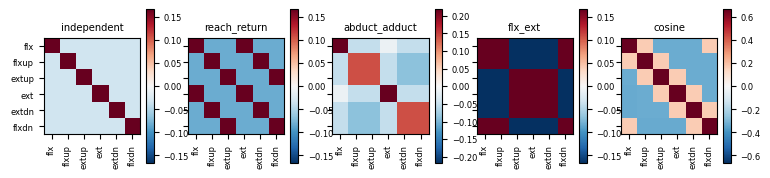

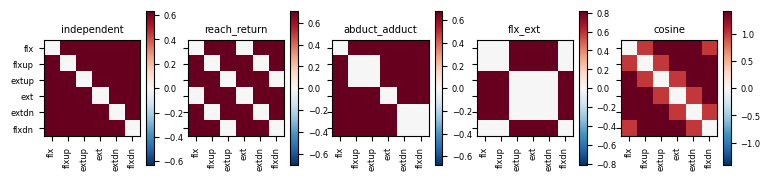

In [19]:
ncond = 6
M = []
modelG = {}
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

# Null model - no information:
cov = np.zeros((ncond, ncond))
M_null = pcm.FixedModel('null', cov)
M.append(M_null)

# independent model
cov = np.eye(ncond)
M.append(pcm.FixedModel('independent', cov))
cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
cov = cov/np.trace(cov)
modelG['independent'] = [cov]

# reach and return:
covs = np.tile(np.eye(ncond//2), (2,2))
covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
covs = covs/np.trace(covs)
M_reach_return = pcm.FixedModel('reach_return', covs)
modelG['reach_return'] = [covs]

# abduct adduct:
# covs = np.zeros((ncond,ncond))
covs = np.eye(ncond)
covs[1,2] = 1
covs[2,1] = 1
covs[4,5] = 1
covs[5,4] = 1
covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
covs = covs/np.trace(covs)
M_abduct_adduct = pcm.FixedModel('abduct_adduct', covs)
modelG['abduct_adduct'] = [covs]

# flxion extension:
# covs = np.zeros((ncond,ncond))
covs = np.eye(ncond)
covs[0,1] = 1
covs[0,5] = 1
covs[1,5] = 1
covs[2,4] = 1
covs[3,2] = 1
covs[3,4] = 1
covs[1,0] = 1
covs[5,0] = 1
covs[5,1] = 1
covs[2,3] = 1
covs[4,3] = 1
covs[4,2] = 1
covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
covs = covs/np.trace(covs)
M_flx_ext = pcm.FixedModel('flx_ext', covs)
modelG['flx_ext'] = [covs]

# Cosine tuning curve model:
angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
corr = np.cos(delta)
# Truncate the cosine: only positive correlations for angles <= 90 deg
# Calculate absolute angular difference in degrees, handling wrap-around
delta_deg = np.abs(angles_deg[:, None] - angles_deg[None, :])
delta_deg = np.minimum(delta_deg, 360 - delta_deg)
# Create a mask for angles > 90 degrees
mask = delta_deg > 90
corr[mask] = 0
corr = pcm.centering(ncond) @ corr @ pcm.centering(ncond)
M_cosine = pcm.FixedModel('cosine', corr)
modelG['cosine'] = [corr]

# ===== Component Models =====
M.append(pcm.ComponentModel('reach_return',[modelG['independent'][0],modelG['reach_return'][0]]))
M.append(pcm.ComponentModel('abduct_adduct',[modelG['independent'][0],modelG['abduct_adduct'][0]]))
M.append(pcm.ComponentModel('cosine',[modelG['independent'][0],modelG['cosine'][0]]))
M.append(pcm.ComponentModel('reach_return+abduct_adduct',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0]]))
M.append(pcm.ComponentModel('reach_return+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['flx_ext'][0]]))
M.append(pcm.ComponentModel('reach_return+abduct_adduct+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['flx_ext'][0]]))

# noise ceiling model:
# M_ceil = pcm.FreeModel('ceil',ncond)
# M.append(M_ceil)

cmap = 'RdBu_r'
model_names = list(modelG.keys())
n = len(model_names)
fix, ax = plt.subplots(1, n, figsize=(9,2), sharey=True)
for i, name in enumerate(model_names):
    vmin = -np.max(np.abs(modelG[name][0]))
    vmax = np.max(np.abs(modelG[name][0]))
    ax[i].imshow(modelG[name][0], cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(name)
    ax[i].set_xticks([0,1,2,3,4,5])
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(modelG[name][0], cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()

fix, ax = plt.subplots(1, n, figsize=(9,2), sharey=True)
for i, name in enumerate(model_names):
    D = pcm.G_to_dist(modelG[name][0])
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(name)
    ax[i].set_xticks([0,1,2,3,4,5])
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks([0,1,2,3,4,5])
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.show()




# Fit model

Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7


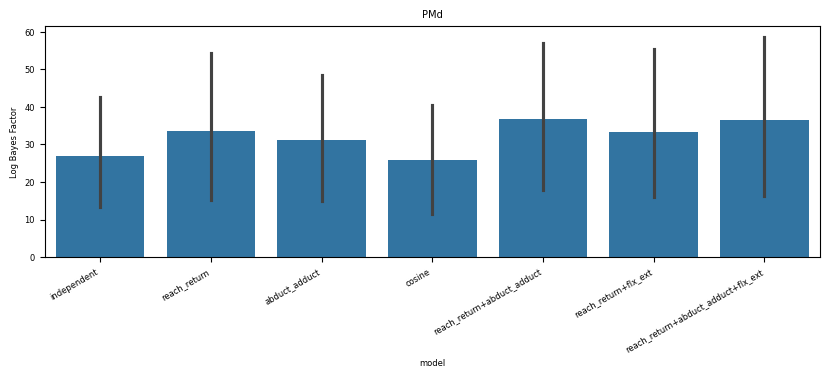

In [20]:
# T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale=True, fixed_effect='block', verbose=False)
T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

# save the results:
import pickle
results = {
           'T_gr': T_gr, 'theta_gr': theta_gr,
           'T_cv': T_cv, 'theta_cv': theta_cv
           }
# with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'wb') as f:
    # pickle.dump(results, f)

fig, ax = plt.subplots(1,1, figsize=(10,3))
ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
# ax.set_ylim(-300, 150)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
plt.show()



# Fit all regions unimanual

Processing region: M1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


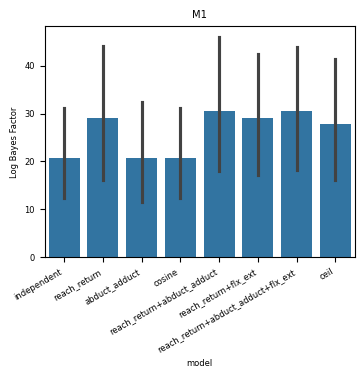

Processing region: S1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


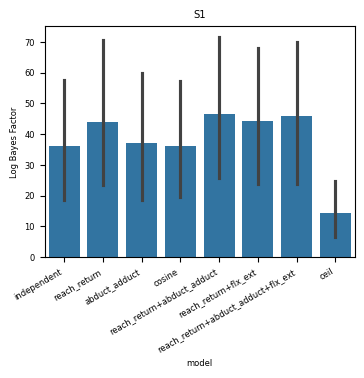

Processing region: PMd
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


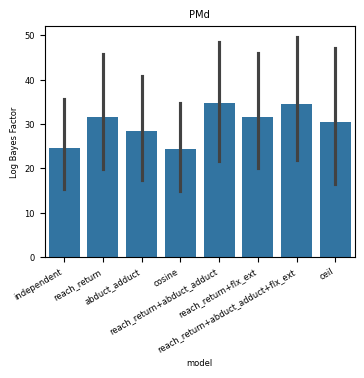

Processing region: PMv
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


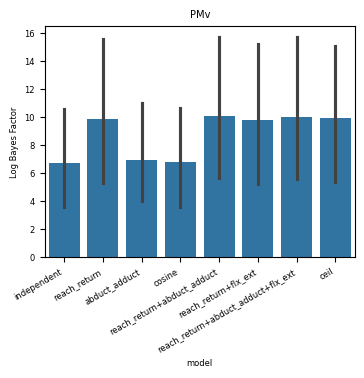

Processing region: SMA
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


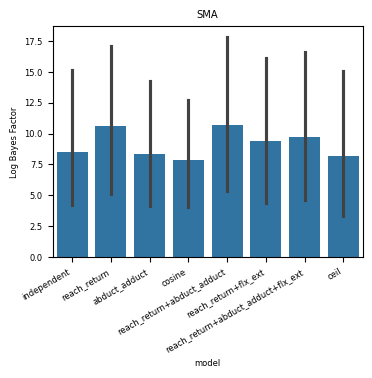

Processing region: SPLa
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


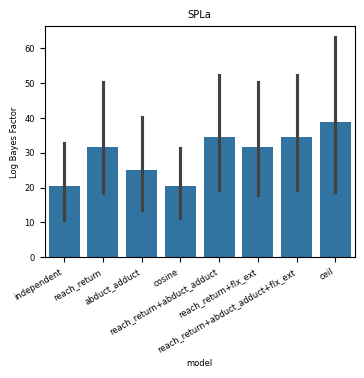

Processing region: SPLp
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


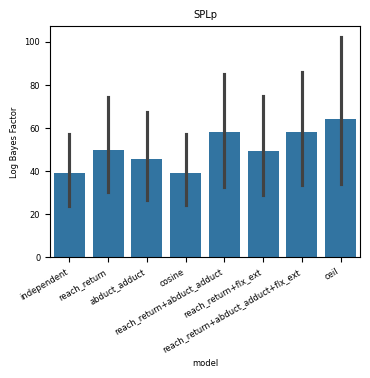

Processing region: V1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


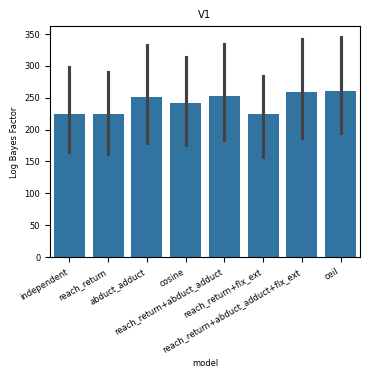

In [15]:
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
conditions = ['lhand', 'rhand', 'lhand', 'rhand']
sn_bad = [102, 103]

for region in regions:
    print(f'Processing region: {region}')
    # ============================ BUILD DATASET ============================
    rois = [f'{region}_R',f'{region}_L',f'{region}_L',f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================ BUILD Models ============================
    ncond = 6
    M = []
    modelG = {}
    labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

    # Null model - no information:
    cov = np.zeros((ncond, ncond))
    M_null = pcm.FixedModel('null', cov)
    M.append(M_null)

    # independent model
    cov = np.eye(ncond)
    M.append(pcm.FixedModel('independent', cov))
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    cov = cov/np.trace(cov)
    modelG['independent'] = [cov]

    # reach and return:
    covs = np.tile(np.eye(ncond//2), (2,2))
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    covs = covs/np.trace(covs)
    M_reach_return = pcm.FixedModel('reach_return', covs)
    modelG['reach_return'] = [covs]

    # abduct adduct:
    # covs = np.zeros((ncond,ncond))
    covs = np.eye(ncond)
    covs[1,2] = 1
    covs[2,1] = 1
    covs[4,5] = 1
    covs[5,4] = 1
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    covs = covs/np.trace(covs)
    M_abduct_adduct = pcm.FixedModel('abduct_adduct', covs)
    modelG['abduct_adduct'] = [covs]

    # flxion extension:
    # covs = np.zeros((ncond,ncond))
    covs = np.eye(ncond)
    covs[0,1] = 1
    covs[0,5] = 1
    covs[1,5] = 1
    covs[2,4] = 1
    covs[3,2] = 1
    covs[3,4] = 1
    covs[1,0] = 1
    covs[5,0] = 1
    covs[5,1] = 1
    covs[2,3] = 1
    covs[4,3] = 1
    covs[4,2] = 1
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    covs = covs/np.trace(covs)
    M_flx_ext = pcm.FixedModel('flx_ext', covs)
    modelG['flx_ext'] = [covs]

    # Cosine tuning curve model:
    angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
    corr = np.cos(delta)
    # Truncate the cosine: only positive correlations for angles <= 90 deg
    # Calculate absolute angular difference in degrees, handling wrap-around
    delta_deg = np.abs(angles_deg[:, None] - angles_deg[None, :])
    delta_deg = np.minimum(delta_deg, 360 - delta_deg)
    # Create a mask for angles > 90 degrees
    mask = delta_deg > 90
    corr[mask] = 0
    corr = pcm.centering(ncond) @ corr @ pcm.centering(ncond)
    M_cosine = pcm.FixedModel('cosine', corr)
    modelG['cosine'] = [corr]

    # ===== Component Models =====
    M.append(pcm.ComponentModel('reach_return',[modelG['independent'][0],modelG['reach_return'][0]]))
    M.append(pcm.ComponentModel('abduct_adduct',[modelG['independent'][0],modelG['abduct_adduct'][0]]))
    M.append(pcm.ComponentModel('cosine',[modelG['independent'][0],modelG['cosine'][0]]))
    M.append(pcm.ComponentModel('reach_return+abduct_adduct',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0]]))
    M.append(pcm.ComponentModel('reach_return+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['flx_ext'][0]]))
    M.append(pcm.ComponentModel('reach_return+abduct_adduct+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['flx_ext'][0]]))

    # noise ceiling model:
    M_ceil = pcm.FreeModel('ceil',ncond)
    M.append(M_ceil)
    
    # ============================ FIT PCM ============================
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

    # save the results:
    import pickle
    results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_direction_encoding_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)

    fig, ax = plt.subplots(1,1, figsize=(4,3))
    ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
    # ax.set_ylim(-300, 150)
    plt.xticks(rotation=30, ha='right')
    plt.title(f'{region}')
    plt.show()




# Fit all regions Marginal

Processing region: M1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


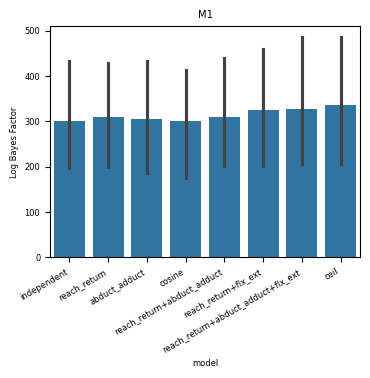

Processing region: S1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


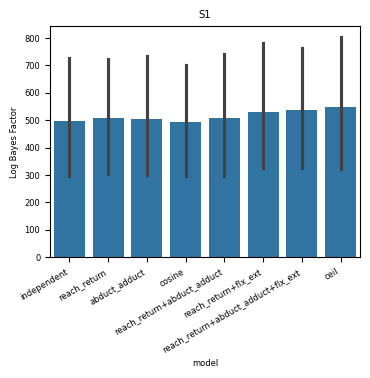

Processing region: PMd
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


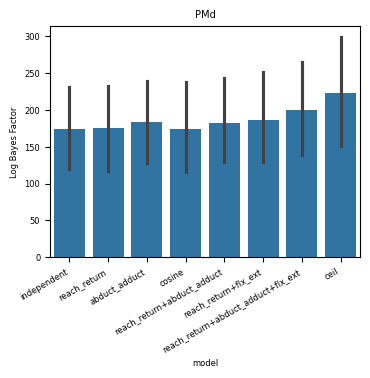

Processing region: PMv
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0
Fitting group cross model 1


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


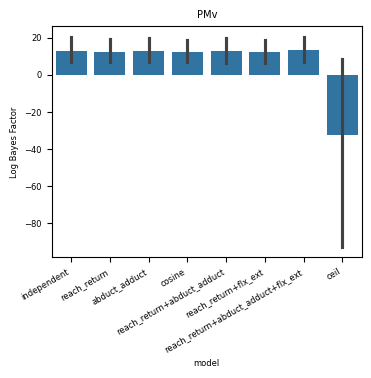

Processing region: SMA
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0
Fitting group cross model 1


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


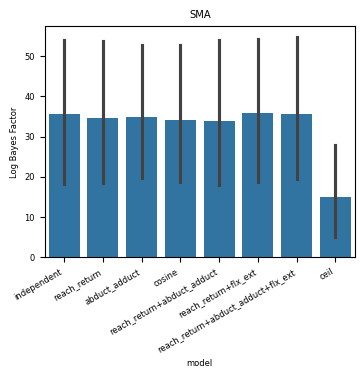

Processing region: SPLa
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


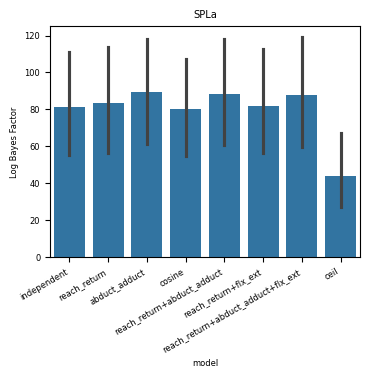

Processing region: SPLp
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


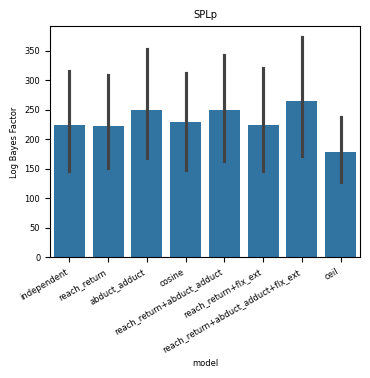

Processing region: V1
Fitting group model 0
Fitting group model 1
Fitting group model 2
Fitting group model 3
Fitting group model 4
Fitting group model 5
Fitting group model 6
Fitting group model 7
Fitting group model 8
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Fitting group cross model 1
Fitting group cross model 2
Fitting group cross model 3
Fitting group cross model 4
Fitting group cross model 5
Fitting group cross model 6
Fitting group cross model 7
Fitting group cross model 8


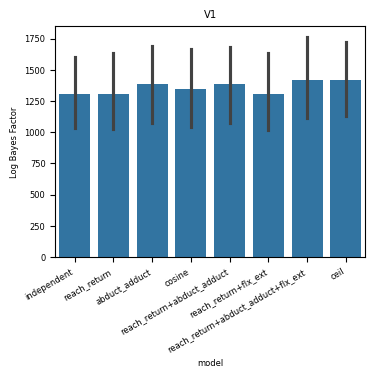

In [156]:
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
conditions = ['lhand_marginal', 'rhand_marginal']
sn_bad = [102, 103]

for region in regions:
    print(f'Processing region: {region}')
    # ============================ BUILD DATASET ============================
    rois = [f'{region}_R',f'{region}_L']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([tmp.endswith(tmp_name) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================ BUILD Models ============================
    ncond = 6
    M = []
    modelG = {}
    labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']

    # Null model - no information:
    cov = np.zeros((ncond, ncond))
    M_null = pcm.FixedModel('null', cov)
    M.append(M_null)

    # independent model
    cov = np.eye(ncond)
    M.append(pcm.FixedModel('independent', cov))
    cov = pcm.centering(ncond) @ cov @ pcm.centering(ncond)
    modelG['independent'] = [cov]

    # reach and return:
    covs = np.tile(np.eye(ncond//2), (2,2))
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    M_reach_return = pcm.FixedModel('reach_return', covs)
    modelG['reach_return'] = [covs]

    # abduct adduct:
    # covs = np.zeros((ncond,ncond))
    covs = np.eye(ncond)
    covs[0,3] = 1
    covs[1,2] = 1
    covs[2,1] = 1
    covs[3,0] = 1
    covs[4,5] = 1
    covs[5,4] = 1
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    M_abduct_adduct = pcm.FixedModel('abduct_adduct', covs)
    modelG['abduct_adduct'] = [covs]

    # flxion extension:
    # covs = np.zeros((ncond,ncond))
    covs = np.eye(ncond)
    covs[0,1] = 1
    covs[0,5] = 1
    covs[3,2] = 1
    covs[3,4] = 1
    covs[1,0] = 1
    covs[5,0] = 1
    covs[2,3] = 1
    covs[4,3] = 1
    covs = pcm.centering(ncond) @ covs @ pcm.centering(ncond)
    M_flx_ext = pcm.FixedModel('flx_ext', covs)
    modelG['flx_ext'] = [covs]

    # Cosine tuning curve model:
    angles_deg = np.array([0, 60, 120, 180, 240, 300], dtype=float)
    delta = np.deg2rad(angles_deg[:, None] - angles_deg[None, :])
    corr = np.cos(delta)        # Correlation: normalized to unit variance
    # corr = corr - np.eye(ncond)
    # keep only off-diagonal values:
    # up_tri2 = np.triu_indices(ncond, k=2)
    # corr[up_tri2] = 0
    # bot_tri2 = np.tril_indices(ncond, k=-2)
    # corr[bot_tri2] = 0
    corr = pcm.centering(ncond) @ corr @ pcm.centering(ncond)
    M_cosine = pcm.FixedModel('cosine', corr)
    modelG['cosine'] = [corr]

    # ===== Component Models =====
    M.append(pcm.ComponentModel('reach_return',[modelG['independent'][0],modelG['reach_return'][0]]))
    M.append(pcm.ComponentModel('abduct_adduct',[modelG['independent'][0],modelG['abduct_adduct'][0]]))
    M.append(pcm.ComponentModel('cosine',[modelG['independent'][0],modelG['cosine'][0]]))
    M.append(pcm.ComponentModel('reach_return+abduct_adduct',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0]]))
    M.append(pcm.ComponentModel('reach_return+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['flx_ext'][0]]))
    M.append(pcm.ComponentModel('reach_return+abduct_adduct+flx_ext',[modelG['independent'][0],modelG['reach_return'][0],modelG['abduct_adduct'][0],modelG['flx_ext'][0]]))

    # noise ceiling model:
    M_ceil = pcm.FreeModel('ceil',ncond)
    M.append(M_ceil)

    # ============================ FIT PCM ============================
    T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

    # save the results:
    import pickle
    results = {
            'T_gr': T_gr, 'theta_gr': theta_gr,
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_direction_encoding_marginal_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)

    fig, ax = plt.subplots(1,1, figsize=(4,3))
    ax = pcm.model_plot(T_cv.likelihood,
                        null_model = 'null')
    # ax.set_ylim(-300, 150)
    plt.xticks(rotation=30, ha='right')
    plt.title(f'{region}')
    plt.show()



# Plot

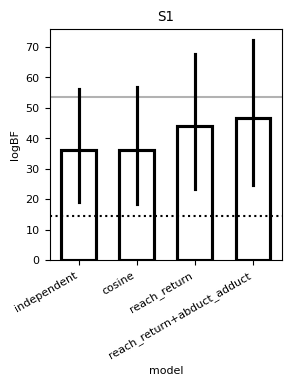

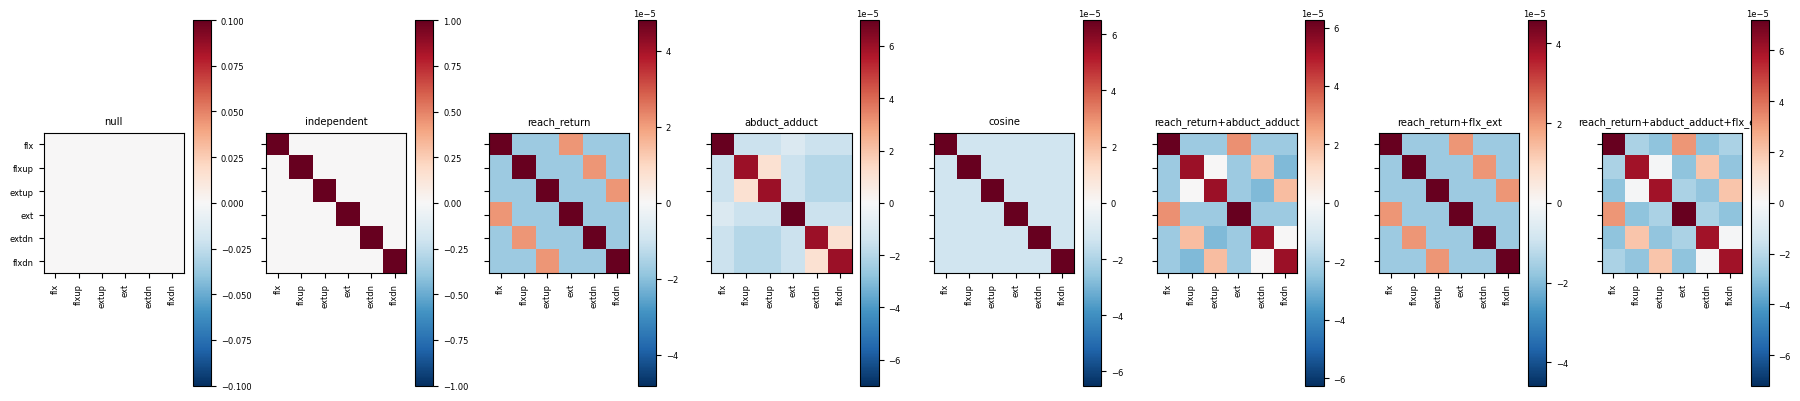

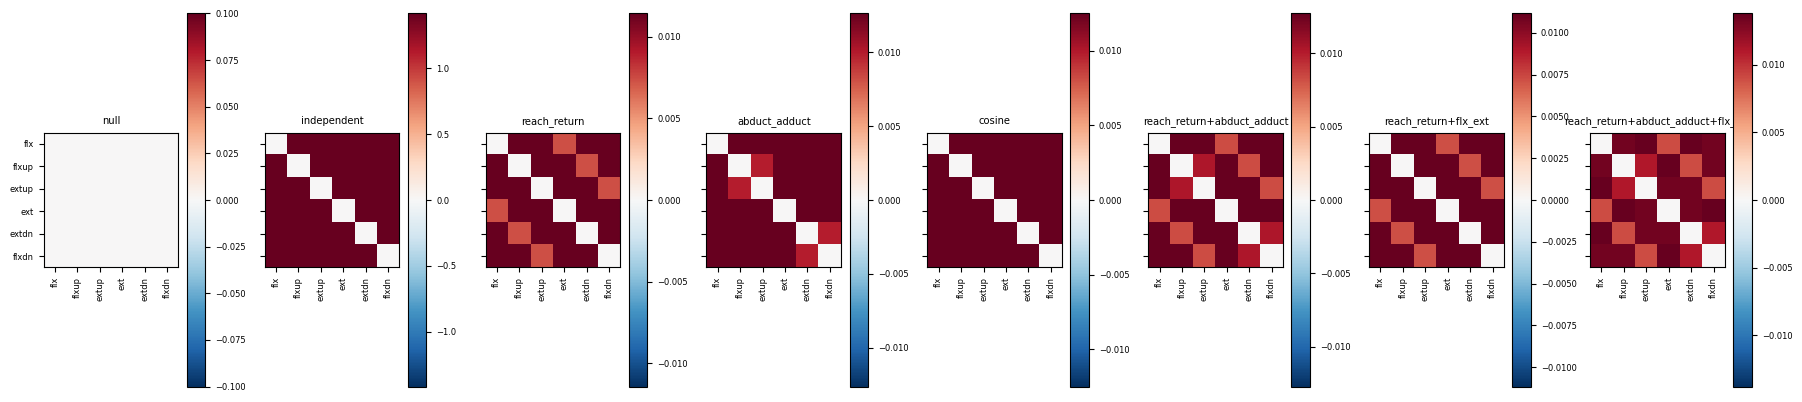

In [14]:
import pickle
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']

# cond_type = 'marginal_'
cond_type = ''

region = 'S1'

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{cond_type}{region}.pkl'), 'rb') as f:
    results = pickle.load(f)
T_gr = results['T_gr']
theta_gr = results['theta_gr']
T_cv = results['T_cv']
theta_cv = results['theta_cv']

ll_gr = T_gr.likelihood
baseline = ll_gr.loc[:,'null'].values
ll_gr = ll_gr - baseline.reshape(-1,1)
ceil_gr = ll_gr['ceil'].values

# =============================== PLOT ===============================
# set font:
matplotlib.rcParams.update({'font.size': 8})

cmap = 'RdBu_r'

# set font:
matplotlib.rcParams.update({'font.size': 8})

fig, ax = plt.subplots(1,1,figsize=(3,3))
likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)

models = [
    'independent',
    'cosine',
    'reach_return',
    'reach_return+abduct_adduct',
    'ceil'
]
sig_pairs = {'M1': [[0,1], [1,2], [0,2]],
             'S1': [[0,1], [1,2], [0,2], [2,3]],
             'PMd': [[0,1], [1,2], [0,2], [2,3]],
             'V1': []}
max_range = {'M1': 80,
             'S1': 110,
             'PMd': 80,
             'V1': 400}

models = [m for m in models if m in likelihood.columns]
likelihood = likelihood[models]
LL = likelihood.melt(var_name='model', value_name='logBF')
ceil = LL[LL['model'] == 'ceil']['logBF'].values
# ax.axhline(0, color='k', linestyle='-', linewidth=1)
sns.barplot(data=LL[LL['model'] != 'ceil'], x='model', y='logBF', ax=ax, fill=False, color='k', width=0.6)
ax.axhline(np.mean(ceil), color='k', linestyle=':', linewidth=1.5)
ax.axhline(np.mean(ceil_gr), color='k', linestyle='-', linewidth=1.5, alpha=0.3)
plt.xticks(rotation=30, ha='right')
plt.title(f'{region}')
# ax.set_ylim((0, max_range[region]))

# utils.please.draw_sig_lines(ax, LL[LL['model'] != 'ceil'], 'model', 'logBF', sig_pairs[region], 
#                             plot_type='barplot', line_height_gap=24, line_height_increase=6)
# utils.please.make_it_pretty(ax)
plt.show()

nmodels = len(M)
# set font:
matplotlib.rcParams.update({'font.size': 6})
# Plot model predictions:
fig, ax = plt.subplots(1, nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    vmin = -np.max(np.abs(G))
    vmax = np.max(np.abs(G))
    ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(6)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(6)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(G, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1,nmodels, figsize=(18,4), sharey=True)
for i in range(nmodels):
    G = M[i].predict(theta_gr[i][:M[i].n_param])[0]
    D = pcm.G_to_dist(G)
    D = np.sign(D) * np.sqrt(np.abs(D))
    vmin = -np.max(np.abs(D))
    vmax = np.max(np.abs(D))
    ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax)
    ax[i].set_title(M[i].name)
    ax[i].set_xticks(list(range(6)))
    ax[i].set_xticklabels(labels, rotation=90)
    ax[i].set_yticks(list(range(6)))
    ax[i].set_yticklabels(labels)
    plt.colorbar(ax[i].imshow(D, cmap=cmap, vmin=vmin, vmax=vmax), ax=ax[i])
plt.tight_layout()
plt.show()


# save best model prediction:
# best_model = 'reach_return+abduct_adduct'
# best_model = 'ceil'
# i = [idx for idx, m in enumerate(M) if m.name == best_model][0]
# G_best = M[i].predict(theta_gr[i][:M[i].n_param])[0]
# file_path_save = os.path.join(analysisDir, f'pcm_Ghat_best_within_model_{region}.npz')
# np.savez(file_path_save, G_hat=G_best)



# STATs

In [17]:
# load model fits:
import pickle
import statsmodels.api as sm

regions = ['M1','S1','PMd','PMv','SMA','SPLa','SPLp','V1']
region = 'S1'

# cond_type = 'marginal_'
cond_type = ''

# load model fitting:
with open(os.path.join(analysisDir, f'PCM_direction_encoding_{cond_type}{region}.pkl'), 'rb') as f:
    results = pickle.load(f)

T_gr = results['T_gr']
theta_gr = results['theta_gr']
nmodels = len(theta_gr)
T_cv = results['T_cv']
theta_cv = results['theta_cv']

# T-test between models:
from scipy import stats

likelihood = T_cv.likelihood
baseline = likelihood.loc[:,'null'].values
likelihood = likelihood - baseline.reshape(-1,1)

models = [
    'independent',
    'cosine',
    'reach_return',
    'reach_return+abduct_adduct',
    'reach_return+flx_ext',
    'reach_return+abduct_adduct+flx_ext',
    'ceil'
]
models = [m for m in models if m in likelihood.columns]
bayesfact = likelihood[models]

# ttest each model > 0:
ttests = {}
for k in bayesfact.keys():
    t, p = stats.ttest_1samp(bayesfact[k], 0, alternative='greater')
    mean = np.mean(bayesfact[k])
    std = np.std(bayesfact[k])
    sem = stats.sem(bayesfact[k])
    ttests[k] = {'t': t, 'p': p, 'dof': len(bayesfact[k])-1, 'mean': mean, 'std': std, 'sem': sem}
    print(f'{k}: t({ttests[k]["dof"]})={t:.2f}, p={p:.4f}, mean={mean:.2f} std={std:.2f} sem={sem:.2f}')

# Model comparisons:
#########################
model1 = 'independent'
model2 = 'cosine'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print('\nModel comparison:')
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'cosine'
model2 = 'reach_return'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")


#########################
model1 = 'independent'
model2 = 'reach_return'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

# differences = bayesfact[model2] - bayesfact[model1]
# plt.figure(figsize=(10, 4))
# plt.subplot(1, 2, 1)
# sns.histplot(differences, kde=True)
# plt.title('Histogram of Differences')

# #    - Visual Check: Q-Q Plot
# plt.subplot(1, 2, 2)
# sm.qqplot(differences, line='s', ax=plt.gca())
# plt.title('Q-Q Plot of Differences')
# plt.show()

# shapiro_stat, shapiro_p = stats.shapiro(differences)
# print(f"Shapiro-Wilk Test: Statistic={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")
# if shapiro_p > 0.05:
#     print("The differences appear to be normally distributed (fail to reject H0).")
# else:
#     print("The differences do not appear to be normally distributed (reject H0).")

#########################
model1 = 'independent'
model2 = 'reach_return+abduct_adduct'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'reach_return'
model2 = 'reach_return+abduct_adduct'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'independent'
model2 = 'reach_return+flx_ext'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'reach_return'
model2 = 'reach_return+flx_ext'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'reach_return'
model2 = 'reach_return+abduct_adduct+flx_ext'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    Statistic={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")

#########################
model1 = 'reach_return+abduct_adduct'
model2 = 'reach_return+abduct_adduct+flx_ext'
t, p = stats.ttest_rel(bayesfact[model2], bayesfact[model1], alternative='greater')
mean_diff = np.mean(bayesfact[model2] - bayesfact[model1])
std_diff = np.std(bayesfact[model2] - bayesfact[model1])
sem_diff = stats.sem(bayesfact[model2] - bayesfact[model1])
dof = len(bayesfact[model2]) - 1
# print(f'Paired t-test {model2} > {model1}: t({dof})={t:.2f}, p={p:.4f}, mean_diff={mean_diff:.2f} std_diff={std_diff:.2f} sem_diff={sem_diff:.2f}')

wilcoxon_stat, wilcoxon_p = stats.wilcoxon(bayesfact[model2], bayesfact[model1], alternative='greater')
print(f"({model2} > {model1}):")
print(f"    W={wilcoxon_stat:.2f}, p-value={wilcoxon_p:.4e}")



independent: t(47)=3.65, p=0.0003, mean=36.24 std=67.98 sem=9.92
cosine: t(47)=3.66, p=0.0003, mean=36.25 std=67.91 sem=9.91
reach_return: t(47)=3.78, p=0.0002, mean=44.08 std=80.00 sem=11.67
reach_return+abduct_adduct: t(47)=3.80, p=0.0002, mean=46.49 std=83.82 sem=12.23
reach_return+flx_ext: t(47)=3.78, p=0.0002, mean=44.20 std=80.08 sem=11.68
reach_return+abduct_adduct+flx_ext: t(47)=3.80, p=0.0002, mean=46.08 std=83.10 sem=12.12
ceil: t(47)=3.01, p=0.0021, mean=14.40 std=32.83 sem=4.79
(cosine > independent):
    Statistic=781.00, p-value=2.3845e-02
(reach_return > cosine):
    Statistic=831.00, p-value=5.9737e-03
(reach_return > independent):
    Statistic=833.00, p-value=5.6172e-03
(reach_return+abduct_adduct > independent):
    Statistic=900.00, p-value=5.2599e-04
(reach_return+abduct_adduct > reach_return):
    Statistic=761.00, p-value=3.8365e-02
(reach_return+flx_ext > independent):
    Statistic=833.00, p-value=5.6172e-03
(reach_return+flx_ext > reach_return):
    Statistic=

# Fit noise ceiling model

In [21]:
regions = ['M1', 'S1', 'PMd', 'PMv', 'SMA', 'SPLa', 'SPLp', 'V1']
labels = ['flx', 'flxup', 'extup', 'ext', 'extdn', 'flxdn']
conditions = ['rhand','lhand','lhand','rhand']

sn_bad = [102, 103]
for region in regions:
    print(f'Processing region: {region}')
    # ============================ BUILD DATASET ============================
    rois = [f'{region}_L', f'{region}_R', f'{region}_L', f'{region}_R']
    data, cond_vec, part_vec = [], [], []
    for roi, condition in zip(rois, conditions):
        file_path = os.path.join(analysisDir, f'pwbeta_{roi}.npz')
        d = np.load(file_path, allow_pickle=True)

        subject = d['subject']
        indices = [k for k, s in enumerate(subject) if s not in sn_bad]
        
        subject = d['subject'][indices]
        cond_name_tmp = d['cond_intrinsic_vec'][indices]
        cond_vec_tmp = d['cond_num_vec'][indices]
        data_tmp = d['beta_white'][indices]
        part_tmp = d['part_vec'][indices]
        
        for i_sub in range(len(subject)):
            # Filter for the current condition
            if condition == 'lhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that left hand goes in that direction:
                        tmp_name = f'bi:{direction}_'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'lhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'rhand_marginal':
                Y = []
                subj_part = []
                subj_cond = []
                # loop on each direction
                for cond_num, direction in enumerate(labels):
                    # in each partition:
                    for k in range(1,11):
                        # bimanual trials that right hand goes in that direction:
                        tmp_name = f'_{direction}'
                        idx1 = np.array([(tmp_name in tmp) for tmp in cond_name_tmp[i_sub]])
                        idx2 = np.array([(k == tmp) for tmp in part_tmp[i_sub]])
                        idx = idx1 & idx2
                        y_tmp = np.mean(data_tmp[i_sub][idx,:], axis=0)
                        Y = np.vstack((Y, y_tmp)) if len(Y) else y_tmp
                    subj_part = np.int64(np.concatenate((subj_part,np.arange(1,11))))
                    condition_name = f'rhand:{direction}'
                    # find the condition numbers corresponding to this condition:
                    idx = (cond_name_tmp[i_sub] == condition_name) & (part_tmp[i_sub] == 1)
                    subj_cond.extend([cond_vec_tmp[i_sub][idx][0]] * 10)

            if condition == 'lhand' or condition == 'rhand':
                # Filter for the current condition
                idx = [j for j, c in enumerate(cond_name_tmp[i_sub]) if condition in c]
                Y = data_tmp[i_sub][idx, :]
                subj_cond = cond_vec_tmp[i_sub][idx]
                subj_part = part_tmp[i_sub][idx]

            data.append(Y)
            cond_vec.append(np.array(subj_cond))
            part_vec.append(subj_part)

    Y = []
    # --- RDM Calculation ---
    for i_sub in range(len(data)):
        obs_des = {'cond_vec': cond_vec[i_sub], 'part_vec': part_vec[i_sub]}
        Y.append(pcm.dataset.Dataset(data[i_sub], obs_descriptors=obs_des))

    # ============================ BUILD Models ============================
    # noise ceiling model:
    M = []
    ncond = 6
    M_ceil = pcm.model.FreeModel('ceil',ncond)
    M.append(M_ceil)


    # ============================ FIT PCM ============================
    # T_in, theta_in = pcm.fit_model_individ(Y, M, fit_scale=True, fixed_effect='block', verbose=False)
    # T_gr, theta_gr = pcm.fit_model_group(Y, M, fit_scale=True)
    T_cv, theta_cv = pcm.fit_model_group_crossval(Y, M, fit_scale=True)

    # save the results:
    import pickle
    results = {
            'T_cv': T_cv, 'theta_cv': theta_cv
            }
    with open(os.path.join(analysisDir, f'PCM_unimanual_CVceiling_{region}.pkl'), 'wb') as f:
        pickle.dump(results, f)




Processing region: M1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: S1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: PMd
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: PMv
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SMA
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SPLa
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: SPLp
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr

Processing region: V1
Fitting group cross model 0


/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:786: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  T['likelihood',m_names[i]][s] = l
/Users/aghavamp/Desktop/Projects/PcmPy/PcmPy/inference.py:788: FutureWarning: ChainedAssignmentErr